## 1. Getting Data

In [13]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision

    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    # !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision

    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https: // github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular.
    !mv pytorch-deep-learning/helper_functions.py.  # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [16]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

In [17]:
# setup training and test path

train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment

## 3. EffNetB2

```import torchvision
# 1. setup pretrained effnetb2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
# 2. get effnetb2 transforms
effnetb2_transforms = effnetb2_weights.transforms()
# 3. setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="Default"
# 4. freeze the base layer in the model
for param in effnetb2.parameters():
    param.requires_grad = False
# 5. set classifier
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

In [18]:
def creat_effnetb2_model(num_classes: int = 3,
                         seed: int = 42):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)
    for param in model.parameters():
        param.requires_grad = False
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )
    return model, transforms

In [19]:
effnetb2, effnetb2_transforms = creat_effnetb2_model(num_classes=3, seed=42)

In [20]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [21]:
from going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 test_transform=effnetb2_transforms,
                                                                                                 batch_size=32,
                                                                                                 num_workers=0)

In [22]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [18]:
from going_modular import engine

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9791 | train_acc: 0.5729 | test_loss: 0.7367 | test_acc: 0.9284
Epoch: 2 | train_loss: 0.7109 | train_acc: 0.8583 | test_loss: 0.5853 | test_acc: 0.9472
Epoch: 3 | train_loss: 0.5903 | train_acc: 0.8896 | test_loss: 0.4856 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4504 | train_acc: 0.9042 | test_loss: 0.4317 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4316 | train_acc: 0.8958 | test_loss: 0.3888 | test_acc: 0.9290
Epoch: 6 | train_loss: 0.4412 | train_acc: 0.8792 | test_loss: 0.3478 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4319 | train_acc: 0.8771 | test_loss: 0.3224 | test_acc: 0.9625
Epoch: 8 | train_loss: 0.3903 | train_acc: 0.8979 | test_loss: 0.3423 | test_acc: 0.9290
Epoch: 9 | train_loss: 0.3747 | train_acc: 0.8938 | test_loss: 0.3101 | test_acc: 0.9256
Epoch: 10 | train_loss: 0.3657 | train_acc: 0.8667 | test_loss: 0.2781 | test_acc: 0.9625


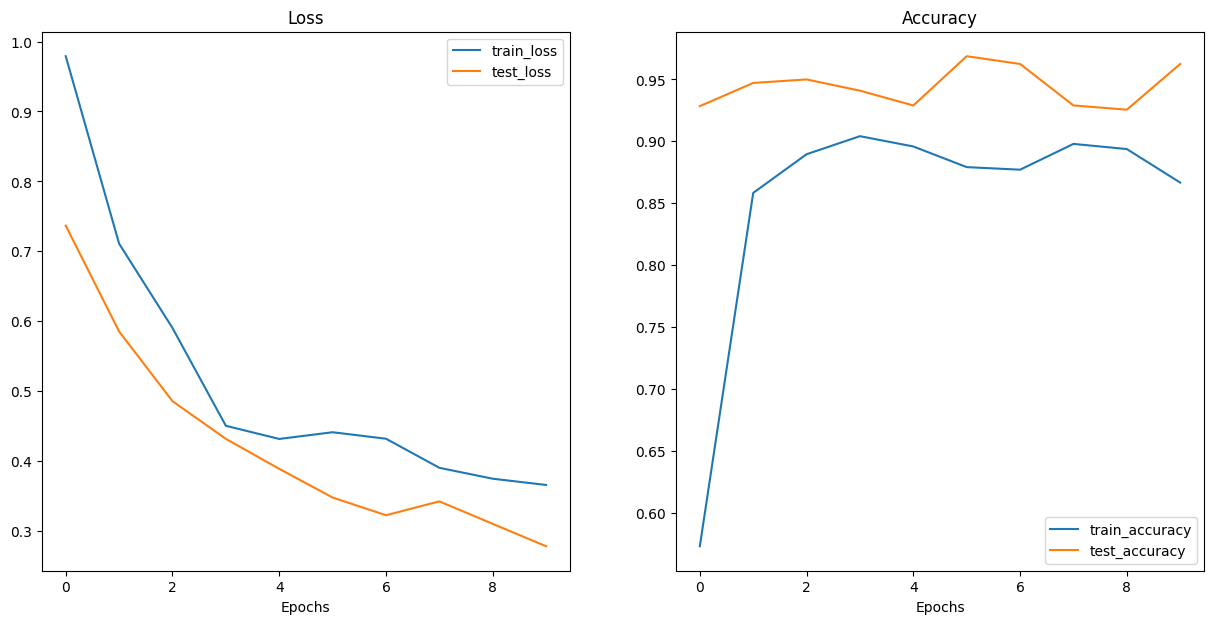

In [19]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [20]:
from going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20.pth")

[INFO] Saving model to: models\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20.pth


Size

In [14]:
from pathlib import Path

pretrained_effnetb2_model_size = Path(
    "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained EFFNET_B2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)}MB")

Pretrained EFFNET_B2 feature extractor model size: 29.86MB


Number of Parameters

In [15]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [16]:
effnetb2_state = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_state

{'test_loss': 0.27809312045574186,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.855069160461426}

# ViT Extractor

In [17]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [18]:
def create_vit_model(num_classes: int = 3,
                     seed: int = 42):
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768,
                                          out_features=num_classes))
    return model, transforms

In [19]:
vit, vit_transforms = create_vit_model()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [20]:
from going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       test_transform=vit_transforms,
                                                                                       batch_size=32,
                                                                                       num_workers=0)

len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [21]:
from going_modular import engine

optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


In [22]:
device

'cuda'

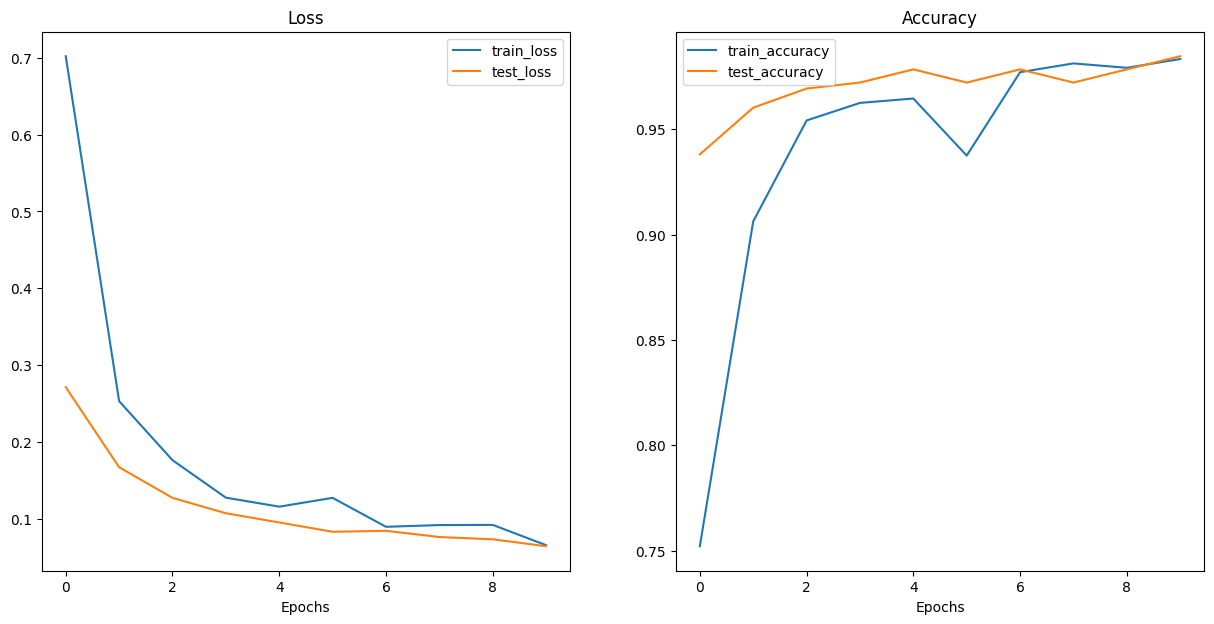

In [23]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [24]:
from going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20.pth")


[INFO] Saving model to: models\09_pretrained_vit_feature_extractor_pizza_steak_sushi_20.pth


In [25]:
from pathlib import Path

pretrained_vit_model_size = Path(
    "models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained vit feature extractor model size: {round(pretrained_vit_model_size, 2)}MB")

Pretrained vit feature extractor model size: 327.37MB


In [26]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [27]:
vit_state = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}
vit_state

{'test_loss': 0.06443451130762697,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3691511154175}

In [28]:
from pathlib import Path

test_data_paths = list(Path(test_dir).glob("*/*"))
test_data_paths[:5]

[WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg')]

In [29]:
import pathlib
import torch

from PIL import Image
from typing import List, Dict
from timeit import default_timer as timer
from tqdm.auto import tqdm


def pred_and_store(paths: list[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    pred_list = []
    for path in tqdm(paths):
        pred_dict = {"image_path": path}
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        start_time = timer()

        img = Image.open(path)

        transformed_image = transform(img).unsqueeze(0).to(device)

        model = model.to(device)

        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]

            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            ent_time = timer()
            pred_dict["time_for_pred"] = round(ent_time - start_time, 4)

        pred_dict["correct"] = class_name == pred_class

        pred_list.append(pred_dict)

    return pred_list


In [30]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")


  0%|          | 0/150 [00:00<?, ?it/s]

In [31]:
effnetb2_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9943,
  'pred_class': 'pizza',
  'time_for_pred': 0.3422,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.4779,
  'pred_class': 'pizza',
  'time_for_pred': 0.3791,
  'correct': True}]

In [32]:
import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9943,pizza,0.3422,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.4779,pizza,0.3791,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9911,pizza,0.2971,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.6986,pizza,0.2733,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.7563,pizza,0.2534,True


In [33]:
effnetb2_test_pred_df.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [34]:
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}")

EffNetB2 average time per prediction: 0.2756


In [35]:
effnetb2_state["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_state

{'test_loss': 0.27809312045574186,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.855069160461426,
 'time_per_pred_cpu': 0.2756}

In [36]:
ViT_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")
ViT_test_pred_df = pd.DataFrame(ViT_test_pred_dicts)


  0%|          | 0/150 [00:00<?, ?it/s]

In [37]:
ViT_test_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [38]:
ViT_average_time_per_pred = round(ViT_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {ViT_average_time_per_pred}")

ViT average time per prediction: 0.351


In [39]:
vit_state["time_per_pred_cpu"] = ViT_average_time_per_pred
vit_state

{'test_loss': 0.06443451130762697,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3691511154175,
 'time_per_pred_cpu': 0.351}

In [40]:
df = pd.DataFrame([effnetb2_state, vit_state])

df["model"] = ["EffNetB2", "ViT"]

df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.278093,96.25,7705221,29.855069,0.2756,EffNetB2
1,0.064435,98.47,85800963,327.369151,0.3510,ViT


In [41]:
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model")
                   .loc["EffNetB2"]), columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.231701,1.023065,11.135432,10.965279,1.273585


c:\All Python Projects\Interpreters\in_Machine_Learning_GPU118\Lib\site-packages\matplotlib\collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


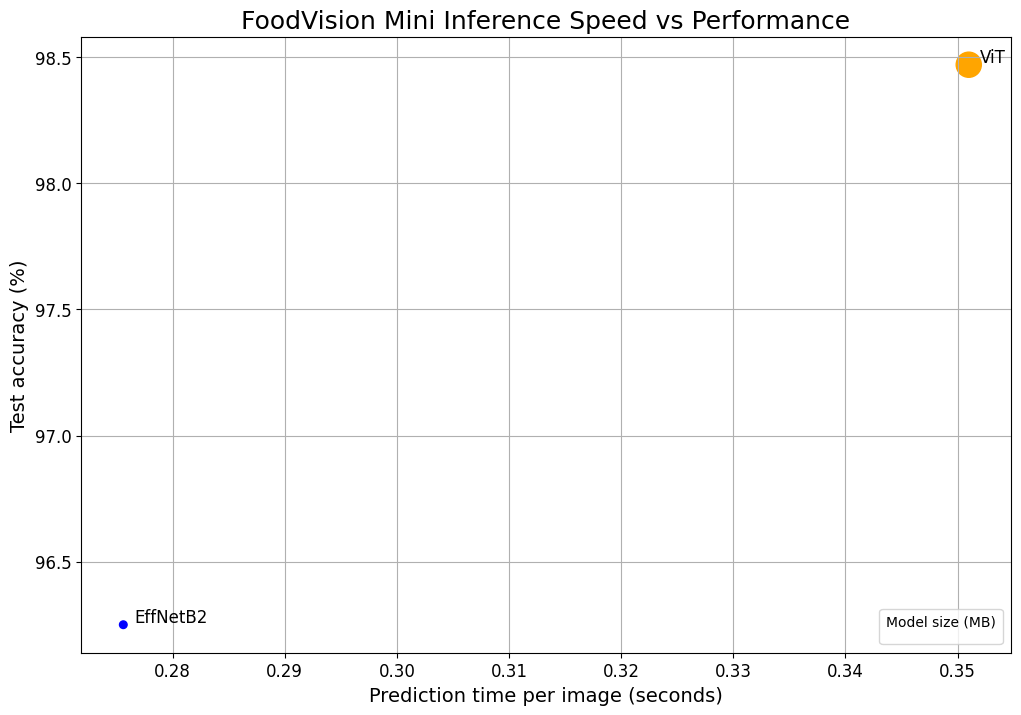

In [42]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

for index, row in df.iterrows():
    ax.annotate(text=row["model"],
                xy=(row["time_per_pred_cpu"] + 0.001, row["test_acc"] + 0.01),
                size=12)

handles, labels = scatter.legend_elements(prob="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

plt.savefig("food_vision Mini inference speed vs performance.png")

In [23]:
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

In [24]:
effnetb2 = effnetb2.to("cpu")

next(iter(effnetb2.parameters())).device

device(type='cpu')

In [25]:
from typing import Tuple, Dict


def predict(img) -> Tuple[Dict, float]:
    start_time = timer()
    img = effnetb2_transforms(img).unsqueeze(0)  # unsqueeze = add batch dimension on 0th dimension#%% md

## 1. Getting Data

In [26]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision

    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    # !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision

    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [28]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https: // github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular.
    !mv pytorch-deep-learning/helper_functions.py.  # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [49]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

In [50]:
# setup training and test path

train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment

## 3. EffNetB2

```import torchvision
# 1. setup pretrained effnetb2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
# 2. get effnetb2 transforms
effnetb2_transforms = effnetb2_weights.transforms()
# 3. setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="Default"
# 4. freeze the base layer in the model
for param in effnetb2.parameters():
    param.requires_grad = False
# 5. set classifier
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

In [51]:
def creat_effnetb2_model(num_classes: int = 3,
                         seed: int = 42):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)
    for param in model.parameters():
        param.requires_grad = False
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )
    return model, transforms

In [29]:
effnetb2, effnetb2_transforms = creat_effnetb2_model(num_classes=3, seed=42)

In [30]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [31]:
from going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 test_transform=effnetb2_transforms,
                                                                                                 batch_size=32,
                                                                                                 num_workers=0)

In [32]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [56]:
from going_modular import engine

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9791 | train_acc: 0.5729 | test_loss: 0.7367 | test_acc: 0.9284
Epoch: 2 | train_loss: 0.7109 | train_acc: 0.8583 | test_loss: 0.5853 | test_acc: 0.9472
Epoch: 3 | train_loss: 0.5903 | train_acc: 0.8896 | test_loss: 0.4856 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4504 | train_acc: 0.9042 | test_loss: 0.4317 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4316 | train_acc: 0.8958 | test_loss: 0.3888 | test_acc: 0.9290
Epoch: 6 | train_loss: 0.4412 | train_acc: 0.8792 | test_loss: 0.3478 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4319 | train_acc: 0.8771 | test_loss: 0.3224 | test_acc: 0.9625
Epoch: 8 | train_loss: 0.3903 | train_acc: 0.8979 | test_loss: 0.3423 | test_acc: 0.9290
Epoch: 9 | train_loss: 0.3747 | train_acc: 0.8938 | test_loss: 0.3101 | test_acc: 0.9256
Epoch: 10 | train_loss: 0.3657 | train_acc: 0.8667 | test_loss: 0.2781 | test_acc: 0.9625


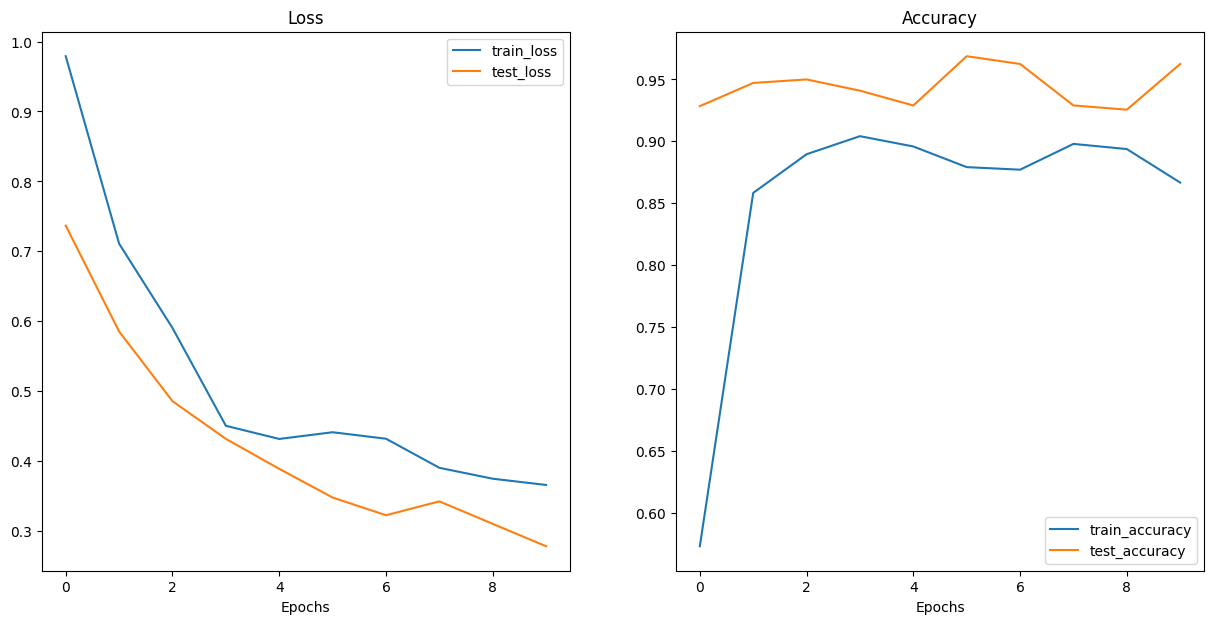

In [57]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [58]:
from going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20.pth")

[INFO] Saving model to: models\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20.pth


Size

In [59]:
from pathlib import Path

pretrained_effnetb2_model_size = Path(
    "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained EFFNET_B2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)}MB")

Pretrained EFFNET_B2 feature extractor model size: 29.86MB


Number of Parameters

In [60]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [61]:
effnetb2_state = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_state

{'test_loss': 0.27809312045574186,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.855069160461426}

# ViT Extractor

In [62]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [63]:
def create_vit_model(num_classes: int = 3,
                     seed: int = 42):
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768,
                                          out_features=num_classes))
    return model, transforms

In [64]:
vit, vit_transforms = create_vit_model()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [65]:
from going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       test_transform=vit_transforms,
                                                                                       batch_size=32,
                                                                                       num_workers=0)

len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [66]:
from going_modular import engine

optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


In [67]:
device

'cuda'

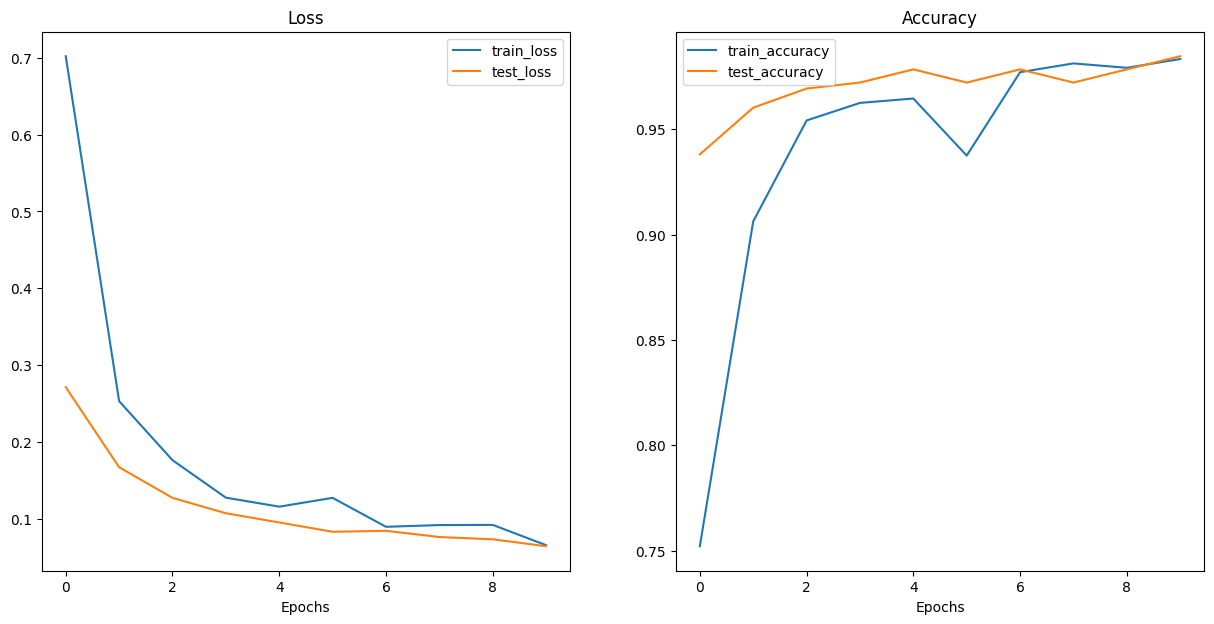

In [68]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [69]:
from going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20.pth")


[INFO] Saving model to: models\09_pretrained_vit_feature_extractor_pizza_steak_sushi_20.pth


In [70]:
from pathlib import Path

pretrained_vit_model_size = Path(
    "models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained vit feature extractor model size: {round(pretrained_vit_model_size, 2)}MB")

Pretrained vit feature extractor model size: 327.37MB


In [71]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [72]:
vit_state = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}
vit_state

{'test_loss': 0.06443451950326562,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3691511154175}

In [73]:
from pathlib import Path

test_data_paths = list(Path(test_dir).glob("*/*"))
test_data_paths[:5]

[WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg')]

In [74]:
import pathlib
import torch

from PIL import Image
from typing import List, Dict
from timeit import default_timer as timer
from tqdm.auto import tqdm


def pred_and_store(paths: list[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    pred_list = []
    for path in tqdm(paths):
        pred_dict = {"image_path": path}
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        start_time = timer()

        img = Image.open(path)

        transformed_image = transform(img).unsqueeze(0).to(device)

        model = model.to(device)

        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]

            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            ent_time = timer()
            pred_dict["time_for_pred"] = round(ent_time - start_time, 4)

        pred_dict["correct"] = class_name == pred_class

        pred_list.append(pred_dict)

    return pred_list


In [75]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")


  0%|          | 0/150 [00:00<?, ?it/s]

In [76]:
effnetb2_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9943,
  'pred_class': 'pizza',
  'time_for_pred': 0.3737,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.4779,
  'pred_class': 'pizza',
  'time_for_pred': 0.277,
  'correct': True}]

In [77]:
import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9943,pizza,0.3737,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.4779,pizza,0.2770,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9911,pizza,0.2749,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.6986,pizza,0.3402,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.7563,pizza,0.3054,True


In [78]:
effnetb2_test_pred_df.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [79]:
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}")

EffNetB2 average time per prediction: 0.2704


In [80]:
effnetb2_state["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_state

{'test_loss': 0.27809312045574186,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.855069160461426,
 'time_per_pred_cpu': 0.2704}

In [81]:
ViT_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")
ViT_test_pred_df = pd.DataFrame(ViT_test_pred_dicts)


  0%|          | 0/150 [00:00<?, ?it/s]

In [82]:
ViT_test_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [83]:
ViT_average_time_per_pred = round(ViT_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {ViT_average_time_per_pred}")

ViT average time per prediction: 0.3616


In [84]:
vit_state["time_per_pred_cpu"] = ViT_average_time_per_pred
vit_state

{'test_loss': 0.06443451950326562,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3691511154175,
 'time_per_pred_cpu': 0.3616}

In [85]:
df = pd.DataFrame([effnetb2_state, vit_state])

df["model"] = ["EffNetB2", "ViT"]

df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.278093,96.25,7705221,29.855069,0.2704,EffNetB2
1,0.064435,98.47,85800963,327.369151,0.3616,ViT


In [86]:
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model")
                   .loc["EffNetB2"]), columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.231701,1.023065,11.135432,10.965279,1.337278


c:\All Python Projects\Interpreters\in_Machine_Learning_GPU118\Lib\site-packages\matplotlib\collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


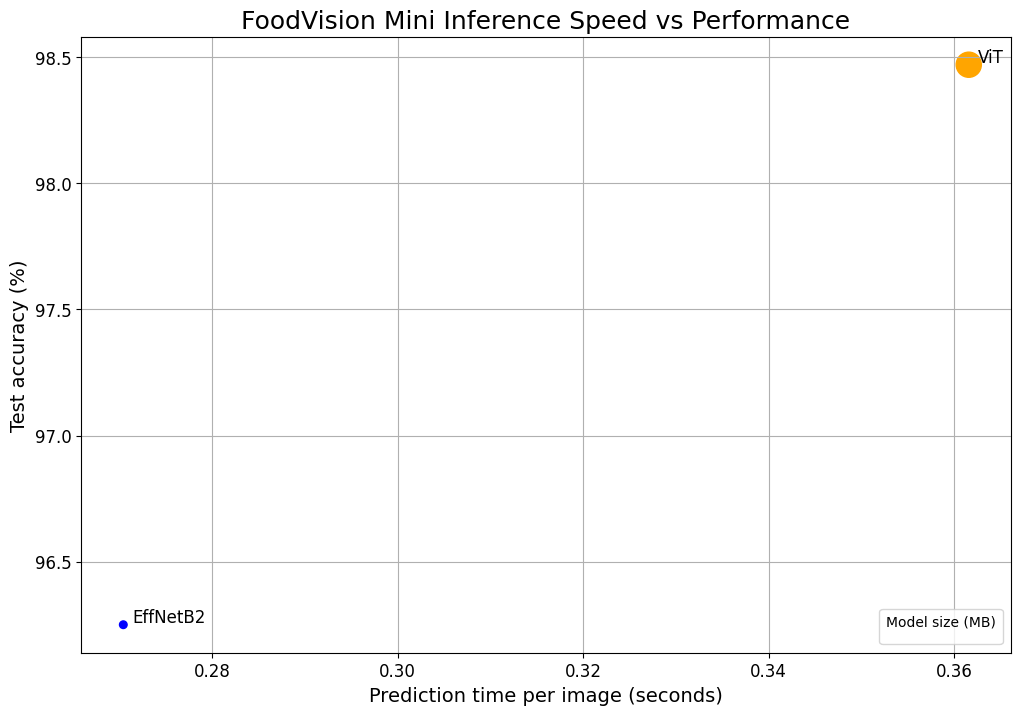

In [87]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

for index, row in df.iterrows():
    ax.annotate(text=row["model"],
                xy=(row["time_per_pred_cpu"] + 0.001, row["test_acc"] + 0.01),
                size=12)

handles, labels = scatter.legend_elements(prob="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

plt.savefig("food_vision Mini inference speed vs performance.png")

In [33]:
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

In [34]:
effnetb2 = effnetb2.to("cpu")

next(iter(effnetb2.parameters())).device

device(type='cpu')

In [35]:
from typing import Tuple, Dict


def predict(img) -> Tuple[Dict, float]:
    start_time = timer()
    img = effnetb2_transforms(img).unsqueeze(0)  # unsqueeze = add batch dimension on 0th dimension
    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    pred_time = round(timer() - start_time, 4)

    return pred_labels_and_probs, pred_time

In [36]:
import random
from PIL import Image
from timeit import timeit as timer

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
# test_data_paths[0]

random_image_path = random.sample(test_data_paths, k=1)[0]
# random_image_path

image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

[INFO] Predicting on image at path: data\pizza_steak_sushi_20_percent\test\sushi\2903621.jpg

{'pizza': 0.2797609567642212, 'steak': 0.2940504252910614, 'sushi': 0.426188588142395}
-0.014


In [37]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data\\pizza_steak_sushi_20_percent\\test\\steak\\3497585.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\sushi\\2378406.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\steak\\3553838.jpg']]

In [96]:
import gradio as gr

title = "FoodVision Mini😊"
description = "An [EffNetB2 feature extractor](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html) computer vision model to classify images as pizza, steak and sushi"
article = "Create at [09. PyTorch Model Deployment](http://keivanjamali.com)."

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction Time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch(debug=False, share=True)

Running on local URL:  http://127.0.0.1:7863

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\All Python Projects\Interpreters\in_Machine_Learning_GPU118\Lib\site-packages\gradio\queueing.py", line 223, in push
    event_queue = self.event_queue_per_concurrency_id[event.concurrency_id]
                  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
KeyError: '2463725524352'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\All Python Projects\Interpreters\in_Machine_Learning_GPU118\Lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 407, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\All Python Projects\Interpreters\in_Machine_Learning_GPU118\Lib\site-packages\uvicorn\middleware\proxy_headers.py", line 69, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 

In [5]:
import shutil
from pathlib import Path

foodvision_mini_demo_path = Path("demos/foodvision_mini/")

if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)
    
else:
    foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)
    

In [2]:
import shutil
from pathlib import Path

foodvision_mini_examples_path = foodvision_mini_demo_path/"examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path/example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, # source
                 dst=destination) # sestination
    

[INFO] Copying data\pizza_steak_sushi_20_percent\test\sushi\592799.jpg to demos\foodvision_mini\examples\592799.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\steak\3622237.jpg to demos\foodvision_mini\examples\3622237.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\pizza\2582289.jpg to demos\foodvision_mini\examples\2582289.jpg


In [3]:
import os
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/2582289.jpg'], ['examples/3622237.jpg'], ['examples/592799.jpg']]

In [25]:
import shutil

effnetb2_foodvision_mini_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20.pth"
effnetb2_foodvision_mini_destination = foodvision_mini_demo_path/effnetb2_foodvision_mini_path.split("/")[1]

try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_path} to {effnetb2_foodvision_mini_destination}")

    shutil.move(src=effnetb2_foodvision_mini_path,
                dst=effnetb2_foodvision_mini_destination)
    
    print(f"[INFO] Model move complete.")
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_path}, perhaps its already been moved!")
    print(f"[INFO] Model exist at {effnetb2_foodvision_mini_destination}: {effnetb2_foodvision_mini_path}")



[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20.pth to demos\foodvision_mini\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20.pth
[INFO] Model move complete.


In [38]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision
from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False
        
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )
    
    return model, transforms

Writing demos/foodvision_mini/model.py


In [39]:
from demos.foodvision_mini import model
effnetb2_model, effnetb2_transforms_import = model.create_effnetb2_model()
effnetb2_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [8]:
%%writefile demos/foodvision_mini/app.py

import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer

class_names = ["pizza", "steake", "sushi"]

effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3)

effnetb2.load_state_dict(
    torch.load(f"09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20.pth",
               map_location=torch.device("cpu"))
)

def predict(img) -> tuple[dict, float]:
    start_time = timer()
    img = effnetb2_transforms(img).unsqueeze(0)  # unsqueeze = add batch dimension on 0th dimension
    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    pred_time = round(timer() - start_time, 4)

    return pred_labels_and_probs, pred_time


example_list = [["examples/" + example] for example in os.listdir("examples")]


title = "FoodVision Mini😊"
description = "An [EffNetB2 feature extractor](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html) computer vision model to classify images as pizza, steak and sushi"
article = "Create at [09. PyTorch Model Deployment](http://keivanjamali.com)."

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction Time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch()

Writing demos/foodvision_mini/app.py


In [24]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.0.1
torchvision==0.15.2
gradio==4.28.3

Writing demos/foodvision_mini/requirements.txt


In [23]:
torch.__version__, torchvision.__version__, gr.__version__

('2.0.1+cu118', '0.15.2+cu118', '4.28.3')

In [ ]:
from IPython.display import IFrame

IFrame(src="https://huggingface.co/spaces/K1Jamali/Food_Vision_Mini_Course/+", width=900, height=750)

In [40]:
from demos.foodvision_mini.model import create_effnetb2_model


effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [41]:
import torchvision
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])

food101_train_transforms


Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [42]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [43]:
from torchvision import datasets

from pathlib import Path
data_dir = Path("data")

# Get the training data (750 x 101 classes)
train_data = datasets.Food101(root=data_dir,    
                              split="train",
                              transform=food101_train_transforms,
                              download=False)

test_data = datasets.Food101(root=data_dir,    
                              split="test",
                              transform=effnetb2_transforms,
                              download=False)

In [13]:
food101_class_names = train_data.classes

food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [14]:
len(train_data) * 0.2, len(test_data) * 0.2

(15150.0, 5050.0)

In [44]:
import torch

def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
    
    length_1 = int(len(dataset) * split_size)
    length_2 = len(dataset) - length_1
    
    print(f"[INFO] Spliting datase of length {len(dataset)} into ssplits of size: {length_1} and {length_2}")

    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed))
    
    return random_split_1, random_split_2

In [11]:
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)



[INFO] Spliting datase of length 75750 into ssplits of size: 15150 and 60600
[INFO] Spliting datase of length 25250 into ssplits of size: 5050 and 20200


In [12]:
import torch

BATCH_SIZE = 32

train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True)

test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False)

len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

In [ ]:
from going_modular import engine

optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

set_seed()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

In [ ]:
from going_modular import utils

effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

utils.save_model(model=effnetb2_food101,
                 target_dir="models/",
                 model_name=effnetb2_food101_model_path)

In [ ]:
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))


In [ ]:
from pathlib import Path

pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")


In [ ]:
from pathlib import Path

foodvision_big_demo_path = Path("demos/foodvision_big/")

foodvision_big_demo_path.mkdir(parets=True,
                               exist_ok=True)

(foodvision_big_demo_path/"examples").mkdir(parents=True, exist_ok=True)

In [ ]:
foodvision_big_class_names_path = foodvision_big_demo_path/"class_names.txt"
foodvision_big_class_names_path

In [ ]:
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(food101_class_names))

In [ ]:
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in f.readlines()]

In [ ]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision
from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False
        
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )
    
    return model, transforms

In [ ]:
%%writefile demos/foodvision_big/app.py

import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer

with open("class_names.txt", "r") as f:
    class_names = [food_name.strip() for food_name in f.readlines()]

effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=101)

effnetb2.load_state_dict(torch.load(f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
                                    map_location=torch.device("cpu")))

def predict(img) -> tuple[dict, float]:
    start_time = timer()
    img = effnetb2_transforms(img).unsqueeze(0)  # unsqueeze = add batch dimension on 0th dimension
    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    pred_time = round(timer() - start_time, 4)

    return pred_labels_and_probs, pred_time


example_list = [["examples/" + example] for example in os.listdir("examples")]

title = "FoodVision 101 🍔👁️💪"
description = "An [EffNetB2 feature extractor](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html) computer vision model to classify 101 classes of food from the Food101 dataset."
article = "Create at [KeivanJamali.com](http://keivanjamali.com)."

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"),
                             gr.Number(label="Prediction Time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch()



# Full Food Vision Mini

In [5]:
from demos.foodvision_mini.model import create_effnetb2_model
import torchvision
from pathlib import Path
from going_modular import engine
from helper_functions import plot_loss_curves
import torch.utils
from going_modular import utils

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:

effnetb2_food101_full, food101_test_transforms = create_effnetb2_model(num_classes=101)

food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    food101_test_transforms
])

food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [7]:
data_dir = Path("data")

# Get the training data (750 x 101 classes)
train_data = torchvision.datasets.Food101(root=data_dir,    
                              split="train",
                              transform=food101_train_transforms,
                              download=False)

test_data = torchvision.datasets.Food101(root=data_dir,    
                              split="test",
                              transform=food101_test_transforms,
                              download=False)

In [13]:
food101_class_names = train_data.classes

food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
train_data_food101 = train_data
test_data_food101 = test_data

BATCH_SIZE = 32

train_dataloader_food101 = torch.utils.data.DataLoader(dataset=train_data_food101,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=True)

test_dataloader_food101 = torch.utils.data.DataLoader(dataset=test_data_food101,
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=False)

len(train_dataloader_food101), len(test_dataloader_food101)

(2368, 790)

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

[train_step 0 Done.]


0it [00:00, ?it/s]

Epoch: 1 | train_loss: 2.9847 | train_acc: 0.4062 | test_loss: 2.1809 | test_acc: 0.6086


0it [00:00, ?it/s]

[train_step 1 Done.]


0it [00:00, ?it/s]

Epoch: 2 | train_loss: 2.6520 | train_acc: 0.4813 | test_loss: 2.1021 | test_acc: 0.6306


0it [00:00, ?it/s]

[train_step 2 Done.]


0it [00:00, ?it/s]

Epoch: 3 | train_loss: 2.6160 | train_acc: 0.4900 | test_loss: 2.0726 | test_acc: 0.6399
[INFO] Saving model to: models\Pretrained_EffNetB2_Feature_Extractor_Food101.pth
Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


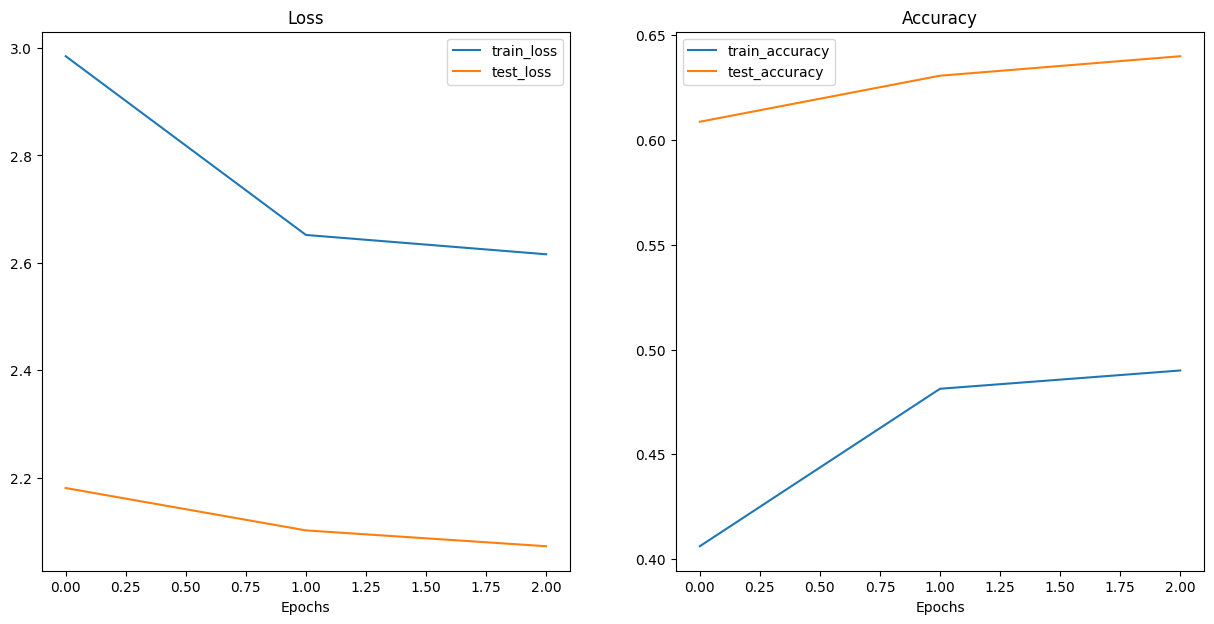

In [9]:
optimizer = torch.optim.Adam(params=effnetb2_food101_full.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

effnetb2_food101_full_results = engine.train(model=effnetb2_food101_full,
                                        train_dataloader=train_dataloader_food101,
                                        test_dataloader=test_dataloader_food101,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=3,
                                        device=device)


plot_loss_curves(effnetb2_food101_full_results)
effnetb2_food101_full_model_path = "Pretrained_EffNetB2_Feature_Extractor_Food101.pth"

utils.save_model(model=effnetb2_food101_full,
                 target_dir="models/",
                 model_name=effnetb2_food101_full_model_path)

loaded_effnetb2_food101_full, _ = create_effnetb2_model(num_classes=101)

loaded_effnetb2_food101_full.load_state_dict(torch.load("models/Pretrained_EffNetB2_Feature_Extractor_Food101.pth"))

pretrained_effnetb2_food101_full_model_size = Path("models", effnetb2_food101_full_model_path).stat().st_size // (1024*1024)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_full_model_size} MB")

In [10]:
from pathlib import Path

foodvision_big_full_demo_path = Path("demos/foodvision_big_full/")

foodvision_big_full_demo_path.mkdir(parents=True,
                                    exist_ok=True)

(foodvision_big_full_demo_path/"examples").mkdir(parents=True, exist_ok=True)

In [11]:
foodvision_big_full_class_names_path = foodvision_big_full_demo_path/"class_names.txt"
foodvision_big_full_class_names_path

WindowsPath('demos/foodvision_big_full/class_names.txt')

In [14]:
with open(foodvision_big_full_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_full_class_names_path}")
    f.write("\n".join(food101_class_names))

[INFO] Saving Food101 class names to demos\foodvision_big_full\class_names.txt


In [15]:
%%writefile demos/foodvision_big_full/model.py
import torch
import torchvision
from torch import nn


def create_effnetb2_model(num_classes:int=101,
                          seed:int=42):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False
        
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )
    
    return model, transforms

Writing demos/foodvision_big_full/model.py


In [22]:
%%writefile demos/foodvision_big_full/app.py

import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer

with open("class_names.txt", "r") as f:
    class_names = [food_name.strip() for food_name in f.readlines()]

effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=101)

effnetb2.load_state_dict(torch.load(f="Pretrained_EffNetB2_Feature_Extractor_Food101.pth",
                                    map_location=torch.device("cpu")))

def predict(img) -> tuple[dict, float]:
    start_time = timer()
    img = effnetb2_transforms(img).unsqueeze(0)  # unsqueeze = add batch dimension on 0th dimension
    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    pred_time = round(timer() - start_time, 4)

    return pred_labels_and_probs, pred_time


example_list = [["examples/" + example] for example in os.listdir("examples")]

title = "Food Vision 101 🍕👁️💪"
description = "An [EffNetB2 feature extractor](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html) computer vision model to classify 101 classes of food from the [Food101](https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html) dataset."
article = "Create at [KeivanJamali.com](http://keivanjamali.com)."

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"),
                             gr.Number(label="Prediction Time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch()



Writing demos/foodvision_big_full/app.py


In [23]:
%%writefile demos/foodvision_big_full/requirements.txt
torch==2.0.1
torchvision==0.15.2
gradio==4.28.3

Writing demos/foodvision_big_full/requirements.txt
